In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score,v_measure_score, completeness_score, homogeneity_score, silhouette_score,roc_curve, auc, f1_score, precision_recall_curve, precision_score,recall_score,accuracy_score,confusion_matrix
import sys
from sklearn.linear_model import LogisticRegression
sys.path.append('/Users/chenpete/Documents/ESP/practicum/autoencoders/code')
from sklearn.model_selection import KFold
from utils import * 
from sklearn.neighbors import BallTree
from sklearn.manifold import TSNE

### Link to Paper

https://arxiv.org/pdf/1809.10717.pdf

In [2]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

non_scale_cols = ['time','y_early','y_rank','y']
param_cols = [
        'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60','x61']

y_col = 'y_early'
early_step = 4

df = pd.read_csv(DATA_DIR + 'paper_mill_rare_events.csv')
df['time'] = pd.to_datetime(df['time'])
X_train, X_test, y_train, y_test,y_rank_train, y_rank_test = preprocess_data(df,param_cols,y_col, non_scale_cols,early_step)

# Model 1: Layer autoencoder

In [3]:
model = simple_ann_autoencoder_regression(param_cols,32,16,32)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1984      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 61)                2013      
Total params: 5,069
Trainable params: 5,069
Non-trainable params: 0
_________________________________________________________________


In [4]:
history_callback = model.fit(X_train,X_train,epochs=75,batch_size = 32)
loss_history = history_callback.history['loss']

Instructions for updating:
Use tf.cast instead.
Epoch 1/75
16007/16007 [==============================] - 1s 40us/step - loss: 0.4560
Epoch 2/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.2399
Epoch 3/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.1979
Epoch 4/75
16007/16007 [==============================] - 0s 25us/step - loss: 0.1777
Epoch 5/75
16007/16007 [==============================] - 0s 25us/step - loss: 0.1639
Epoch 6/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.1521
Epoch 7/75
16007/16007 [==============================] - 0s 25us/step - loss: 0.1414
Epoch 8/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.1320
Epoch 9/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.1247
Epoch 10/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.1192
Epoch 11/75
16007/16007 [==============================] - 0s 26us/step - loss: 0.1145
Epoc

In [5]:
model.save('autoencoder_32_16_32.h5')

Text(0.5, 1.0, 'loss history')

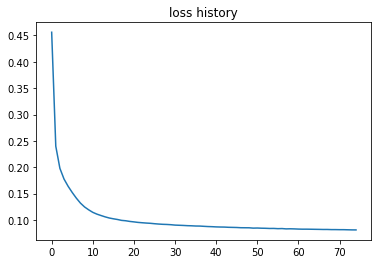

In [6]:
plt.plot(loss_history)
plt.title('loss history')

In [7]:
X_pred_test = model.predict(X_test)

X_pred_train = model.predict(X_train)

df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)

In [8]:
nominal_idx = y_rank_test==0
early1_idx = y_rank_test==1
early2_idx = y_rank_test==2
early3_idx = y_rank_test==3
early4_idx = y_rank_test==4



## Assess errors for each time lag

In [9]:
res_nominal_train = df_results_train[df_results_train['y'] == 0]['residual_avg']

average_res_nominal_train = np.mean(res_nominal_train)
std_res_nominal_train = np.std(res_nominal_train)
threshold_3s = average_res_nominal_train + 3*std_res_nominal_train
threshold_5s = average_res_nominal_train + 5*std_res_nominal_train
threshold_max = np.max(res_nominal_train)

threshold_list = [('3s',threshold_3s),('5s',threshold_5s),('max',threshold_max)]

### Training residuals

(0, 1)

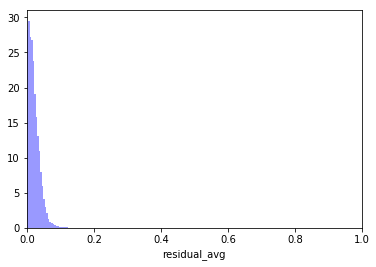

In [10]:
plt.figure()
sns.distplot(df_results_train['residual_avg'],norm_hist=True,kde=False,color='blue')
plt.xlim((0,1))


------------------ early time step of 1----------------------------


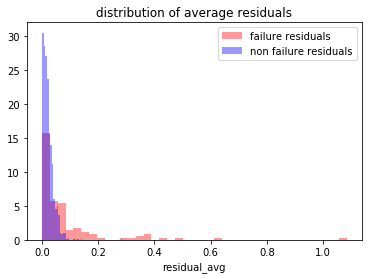

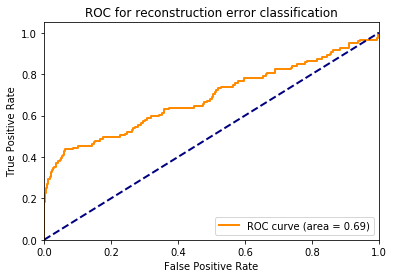



------ Using threshold 3s---------------
accuracy = 0.938
precision = 0.507
recall = 0.303
f1 = 0.379


------ Using threshold 5s---------------
accuracy = 0.948
precision = 0.812
recall = 0.218
f1 = 0.344


------ Using threshold max---------------
accuracy = 0.943
precision = 0.917
recall = 0.092
f1 = 0.168

------------------ early time step of 2----------------------------


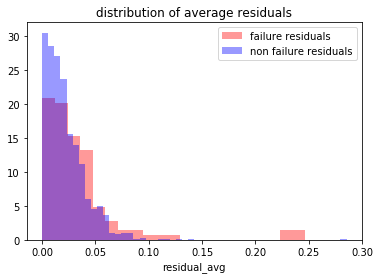

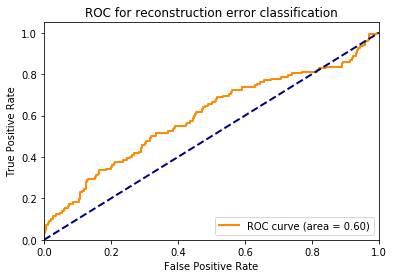



------ Using threshold 3s---------------
accuracy = 0.923
precision = 0.239
recall = 0.090
f1 = 0.131


------ Using threshold 5s---------------
accuracy = 0.936
precision = 0.500
recall = 0.049
f1 = 0.090


------ Using threshold max---------------
accuracy = 0.937
precision = 0.800
recall = 0.033
f1 = 0.063

------------------ early time step of 3----------------------------


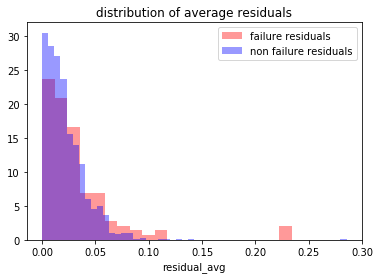

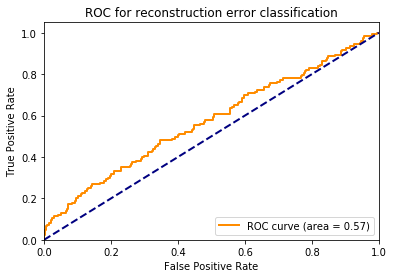



------ Using threshold 3s---------------
accuracy = 0.922
precision = 0.222
recall = 0.081
f1 = 0.119


------ Using threshold 5s---------------
accuracy = 0.935
precision = 0.455
recall = 0.041
f1 = 0.075


------ Using threshold max---------------
accuracy = 0.936
precision = 0.750
recall = 0.024
f1 = 0.047

------------------ early time step of 4----------------------------


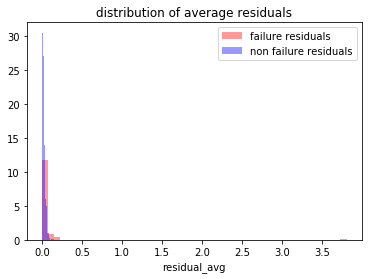

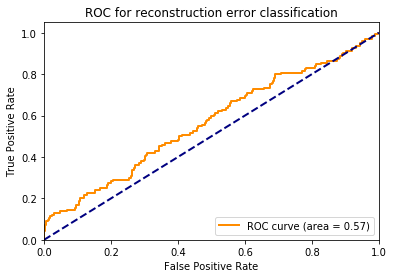



------ Using threshold 3s---------------
accuracy = 0.924
precision = 0.286
recall = 0.113
f1 = 0.162


------ Using threshold 5s---------------
accuracy = 0.935
precision = 0.538
recall = 0.056
f1 = 0.102


------ Using threshold max---------------
accuracy = 0.935
precision = 0.667
recall = 0.016
f1 = 0.031

------------------ early time step of 5----------------------------


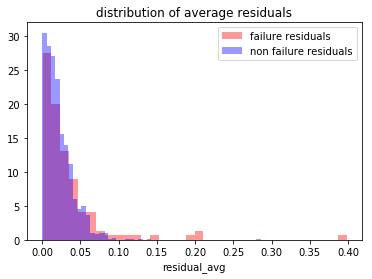

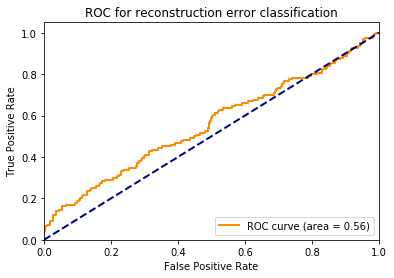



------ Using threshold 3s---------------
accuracy = 0.922
precision = 0.239
recall = 0.089
f1 = 0.129


------ Using threshold 5s---------------
accuracy = 0.935
precision = 0.538
recall = 0.056
f1 = 0.102


------ Using threshold max---------------
accuracy = 0.935
precision = 0.500
recall = 0.008
f1 = 0.016


In [11]:
for rank in range(1,np.max(df_results_test['y_rank'])+1):
    
    print('\n------------------ early time step of {}----------------------------'.format(rank))
    
    df_results_rank= df_results_test[(df_results_test['y_rank']==rank) | (df_results_test['y_rank']==0)]
    res_nominal_test = df_results_rank[df_results_rank['y'] == 0]['residual_avg']
    res_failures_test = df_results_rank[df_results_rank['y_rank'] == rank]['residual_avg']
    
    plt.figure()
    sns.distplot(res_failures_test,norm_hist=True,kde=False,color='red')
    sns.distplot(res_nominal_test,norm_hist=True,kde=False,color='blue')
    plt.legend(['failure residuals','non failure residuals'])
    plt.title('distribution of average residuals')

    y_true = np.array(df_results_rank['y'])
    y_pred_proba = np.array(df_results_rank['residual_avg']/np.max(df_results_rank['residual_avg']))

    plot_roc(y_true,y_pred_proba)
    
    for name,threshold in threshold_list:
        print('\n\n------ Using threshold {}---------------'.format(name))
        y_pred_threshold = np.where(df_results_rank['residual_avg'] > threshold, 1, 0)
        
        print('accuracy = {:.3f}'.format(accuracy_score(y_true,y_pred_threshold)))
        print('precision = {:.3f}'.format(precision_score(y_true,y_pred_threshold)))
        print('recall = {:.3f}'.format(recall_score(y_true,y_pred_threshold)))
        print('f1 = {:.3f}'.format(f1_score(y_true,y_pred_threshold)))


(0, 0.75)

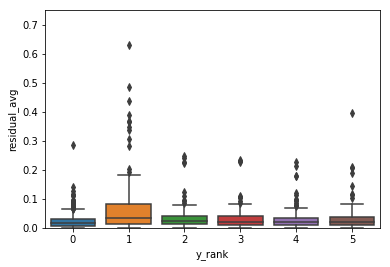

In [12]:
sns.boxplot(x='y_rank',y='residual_avg',data=df_results_test)
plt.ylim((0,.75))

# Try different ways to analyze reconstruction error

In [13]:
residuals_test = X_pred_test - X_test
residuals_train = X_pred_train - X_train

In [14]:
residuals_test = residuals_test[nominal_idx |early1_idx]
y_test_early1 = y_test[nominal_idx |early1_idx]

In [15]:
residuals_train.shape

(16007, 61)

In [16]:
residuals_test.shape

(1898, 61)

### Try std error for early interval = 1

In [17]:
residuals_train_mean = np.abs(np.mean(residuals_train,axis=1))
residuals_train_std = np.std(residuals_train,axis=1)

std_threshold = np.std(residuals_train_std) + 3*np.std(residuals_train_std)
std_threshold

0.39804633758596814

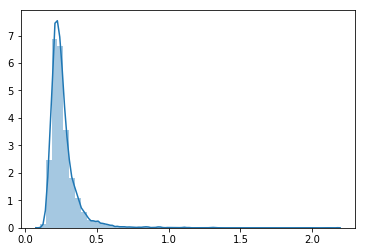

In [18]:
sns.distplot(residuals_train_std)

In [19]:
residuals_test_mean = np.abs(np.mean(residuals_test,axis=1))
residuals_test_std = np.std(residuals_test,axis=1)

In [20]:
residuals_test_std.shape

(1898,)

Text(0.5, 1.0, 'distribution of std residual')

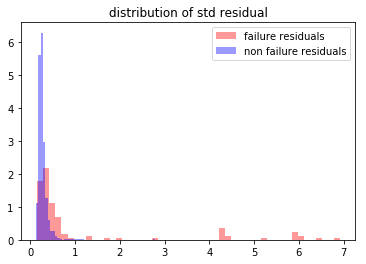

In [21]:
plt.figure()
sns.distplot(residuals_test_std[early1_idx],norm_hist=True,kde=False,color='red')
sns.distplot(residuals_test_std[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of std residual')

In [22]:
y_pred_proba_std = residuals_test_std/np.max(residuals_test_std)

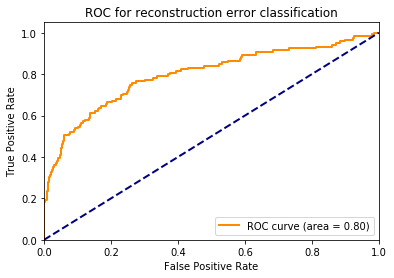

In [23]:
plot_roc(y_test_early1,y_pred_proba_std)

In [24]:
y_pred_threshold_std = np.where(residuals_test_std > std_threshold, 1, 0)

print('accuracy = {:.3f}'.format(accuracy_score(y_test_early1,y_pred_threshold_std)))
print('precision = {:.3f}'.format(precision_score(y_test_early1,y_pred_threshold_std)))
print('recall = {:.3f}'.format(recall_score(y_test_early1,y_pred_threshold_std)))
print('f1 = {:.3f}'.format(f1_score(y_test_early1,y_pred_threshold_std)))

accuracy = 0.901
precision = 0.317
recall = 0.504
f1 = 0.390


### Look at all errors

## KNN on reconstruction error

In [114]:
from sklearn.neighbors import DistanceMetric
#dm = DistanceMetric.get_metric('mahalanobis', V=np.cov(residuals_train))
tree = BallTree(residuals_train,metric ='euclidean')

In [115]:
dist,ind = tree.query(residuals_test,k=1)
dist = pd.Series(dist.ravel(),index=residuals_test.index)

Text(0.5, 1.0, 'distribution of L2 distance for residual')

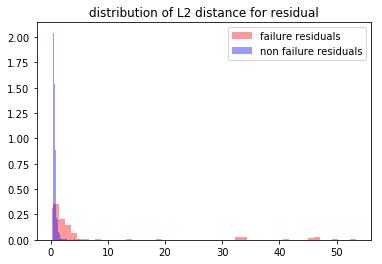

In [116]:
plt.figure()
sns.distplot(dist[early1_idx],norm_hist=True,kde=False,color='red')
sns.distplot(dist[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of L2 distance for residual')

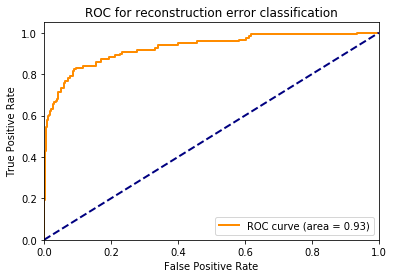

In [117]:
y_pred_proba_knn = dist/np.max(dist)
plot_roc(y_test_early1,y_pred_proba_knn)

In [118]:
y_pred_threshold_knn = np.where(dist > 1.4, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_test_early1,y_pred_threshold_knn)))
print('precision = {:.3f}'.format(precision_score(y_test_early1,y_pred_threshold_knn)))
print('recall = {:.3f}'.format(recall_score(y_test_early1,y_pred_threshold_knn)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_test_early1,y_pred_threshold_knn)))
print(confusion_matrix(y_test_early1,y_pred_threshold_knn))

accuracy = 0.956
precision = 0.661
recall = 0.622
f1 = 0.641


[[1741   38]
 [  45   74]]


# Cross Validation for KNN

In [30]:
# K = 10
# X_train_list, X_test_list, y_train_list, y_test_list,y_rank_train_list, y_rank_test_list = preprocess_data_cv(df,param_cols,y_col, non_scale_cols,early_step, k = K)

In [31]:
# for k in range(K):
    
#     X_train, y_train, y_rank_train = X_train_list[k],y_train_list[k],y_rank_train_list[k]
#     X_test, y_test, y_rank_test = X_test_list[k],y_test_list[k],y_rank_test_list[k]
    
#     nominal_idx = y_rank_test==0
#     early1_idx = y_rank_test==1
    
#     model = simple_ann_autoencoder_regression(param_cols,32,16,32)
#     history_callback = model.fit(X_train,X_train,epochs=75,batch_size = 32,verbose = 0)
    
#     X_pred_test = model.predict(X_test)
#     X_pred_train = model.predict(X_train)

#     df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
#     df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)
    
#     residuals_test = X_pred_test - X_test
#     residuals_train = X_pred_train - X_train
    
#     residuals_test = residuals_test[nominal_idx |early1_idx]
#     y_test_early1 = y_test[nominal_idx |early1_idx]
    
#     tree = BallTree(residuals_train)
    
#     dist,ind = tree.query(residuals_test,k=1)
#     dist = pd.Series(dist.ravel(),index=residuals_test.index)
    
#     y_pred_proba_knn = dist/np.max(dist)
#     plot_roc(y_test_early1,y_pred_proba_knn)

# Try Logistic Regression on reconstruction error

In [32]:
X_residual_train, X_residual_test, y_residual_train, y_residual_test = train_test_split(residuals_test, y_test_early1, test_size=0.5, random_state=0, stratify = y_test_early1)

In [33]:
y_residual_train.value_counts()

0    889
1     60
Name: y_early, dtype: int64

In [34]:
y_residual_test.value_counts()

0    890
1     59
Name: y_early, dtype: int64

In [35]:
clf = LogisticRegression()
clf.fit(X_residual_test,y_residual_test)

y_pred_logreg_proba = clf.predict_proba(X_residual_test)[:,1]

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


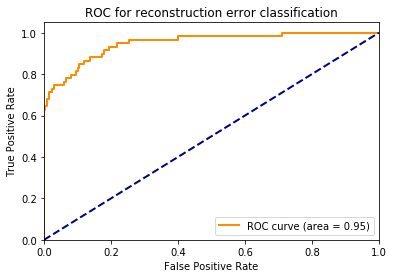

In [36]:
plot_roc(y_residual_test,y_pred_logreg_proba)

Text(0.5, 1.0, 'distribution of logistic regression probability')

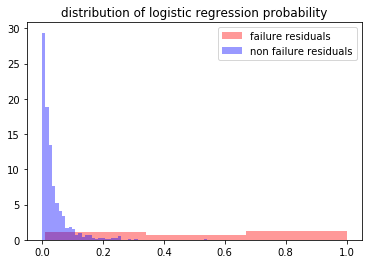

In [70]:
plt.figure()
sns.distplot(y_pred_logreg_proba[y_residual_test==1],norm_hist=True,kde=False,color='red')
sns.distplot(y_pred_logreg_proba[y_residual_test==0],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of logistic regression probability')

In [60]:
y_pred_threshold_logreg = np.where(y_pred_logreg_proba > .4, 1, 0)

print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_threshold_logreg)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_threshold_logreg)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_threshold_logreg)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_threshold_logreg)))
print(confusion_matrix(y_residual_test,y_pred_threshold_logreg))

accuracy = 0.973
precision = 0.971
recall = 0.576
f1 = 0.723


[[889   1]
 [ 25  34]]


## T-sne on reconstruction errors

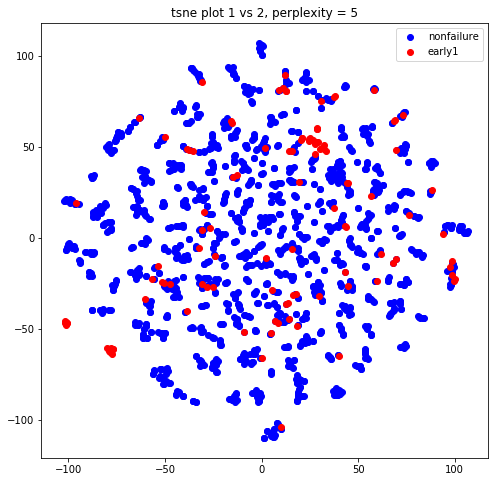

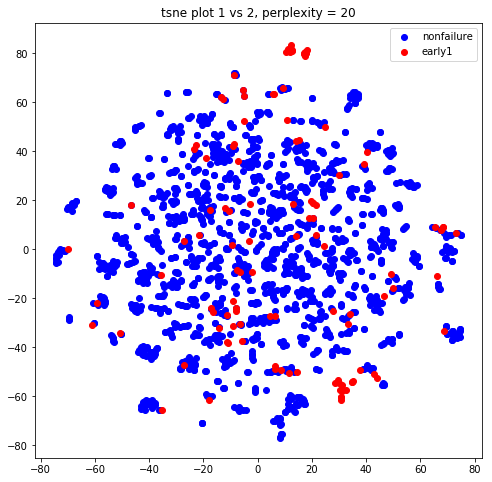

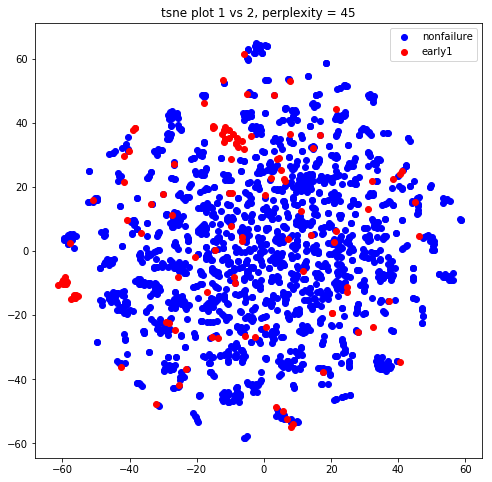

In [50]:
perplexity_list = [5,20,45]

for p in perplexity_list:
    tsne = TSNE(n_components=2,perplexity=p)
    tsne_output = tsne.fit_transform(residuals_test)
    tsne_output1 = pd.Series(tsne_output[:,0],index=residuals_test.index)
    tsne_output2 = pd.Series(tsne_output[:,1],index=residuals_test.index)

    plt.figure(figsize=(8,8))
    plt.scatter(tsne_output1[nominal_idx],tsne_output2[nominal_idx],color='blue')
    plt.scatter(tsne_output1[early1_idx],tsne_output2[early1_idx],color='red')
    plt.legend(['nonfailure','early1'])
    plt.title('tsne plot 1 vs 2, perplexity = {}'.format(p))

### Try K means clustering on reconstruction error 